In [ ]:
import subprocess
import os

# Check JAVA_HOME - ensure java 17 for spark compatibility
result = subprocess.run(['bash', '-c', 'echo $JAVA_HOME'], capture_output=True, text=True)
print(result.stdout)

if os.environ.get('JAVA_HOME'):
    result = subprocess.run([os.environ['JAVA_HOME'] + '/bin/java', '-version'], 
                          capture_output=True, text=True)
    print("\nProject JAVA_HOME Java version:")
    print(result.stderr)

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("local-pyspark").getOrCreate()

In [ ]:
import pandas as pd
import pyarrow.parquet as pq


# Read csv
taxi_df = pd.read_csv("./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.csv")

print(taxi_df.dtypes)

In [ ]:
# Convert to parquet

taxi_df.to_parquet("./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.parquet")
taxi_df.head(5)

In [ ]:
# Check generated statistics in parquet file
pf = pq.ParquetFile("./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.parquet")
print(f"Row groups: {pf.num_row_groups}")
for i in range(pf.num_row_groups):
    rg = pf.metadata.row_group(i)
    print(type(rg))

    print(f"\n--- Row Group {i} ({rg.num_rows:,} rows) ---")
    
    for j in range(rg.num_columns):
        print(f"\n--- Column {j} statistics ---")
        chunk = rg.column(j)
        print(chunk.statistics.to_dict)

In [ ]:
# Time for benchmarking
import time

def timer(func, df, *args, **kwargs):
    """Time Spark operation and return result"""
    start = time.perf_counter()
    result = func(df, *args, **kwargs)
    elapsed = (time.perf_counter() - start) * 1000
    print(f"Time: {elapsed:.2f} ms")
    return result

In [ ]:
# Read parquet file in Spark session
taxi_pq_df = spark.read.parquet("./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.parquet")

### Benchmark Test #1: efficiency gain by using cache

In [ ]:
from pyspark import StorageLevel

df_filtered = taxi_pq_df.filter(taxi_pq_df.passenger_count > 1) #Lazy execution

In [ ]:
# check cache status
print(df_filtered.storageLevel)
print(df_filtered.is_cached)

In [ ]:
start = time.perf_counter()
result = df_filtered.count() #Action triggers real execution
end = time.perf_counter()

print(f"Count WITHOUT cache: {(end - start)*1000:.2f} ms")
print(f"{taxi_pq_df.count()} total rides - {result} rides with multiple passengers")

In [ ]:
# Test: Cache the dataframe and check execution time
df_filtered.persist(StorageLevel.MEMORY_ONLY)
print(df_filtered.storageLevel)
print(df_filtered.is_cached)

# first count triggers caching (caching is also LAZY just like filtering)
# total time therefore is count-time + caching-time
print("Count + cache:")
result = timer(lambda df: df.count(), df_filtered)

In [ ]:
# second count should show speed gains by using cache:
print("Count FROM cache:")
result = timer(lambda df: df.count(), df_filtered)

# Key takeaways: 

* Different cache modes between disk and in-memory, 1 or 2 replications
* Caching/persisting is a LAZY operation, data only gets cached when an ACTION triggers it
* Speed gains are minimal for small datasets

### Benchmark #2: Partitions

In [ ]:
df_partitions = spark.read.parquet("./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.parquet")
df_partitions = df_partitions.filter(df_partitions.passenger_count > 1)

print(f"Partitions: {df_partitions.rdd.getNumPartitions()}")

# Check partition sizes
df_partitions.rdd.glom().map(len).collect()

In [ ]:
print("Count with 6 partitions:")
result = timer(lambda df: df.count(), df_partitions)

In [ ]:
df_repartitioned = df_partitions.repartition(12)

# Check partition sizes
df_repartitioned.rdd.glom().map(len).collect()

In [ ]:
print("Count with 12 partitions:")
result = timer(lambda df: df.count(), df_repartitioned)

### Key Takeaways

* not all partitions necessarely get used: after repartition(12) all partitions got 50k rows, before that some were empty
* Spark GUI shows execution timing. 12 partitions = 12 tasks, my PC has 6 cores and i can see only 6 tasks ran concurrently, as expected
* This means you can process as many partitions in parallel as you have available CPU cores.

### Benchmark #3: shuffling during aggregation actions

In [ ]:
df_aggregation = spark.read.parquet('./nyc-yellow-taxi-trip-records-january-2024/nyc_tlc_yellow_2024_01.parquet')

In [ ]:
from pyspark.sql.functions import sum

#two ways to write an aggregation: list or dict
#df_result = df_aggregation.groupBy("VendorID").agg(sum("fare_amount").alias("total_fares"),sum("trip_distance").alias("distance_travelled"))

df_result = df_aggregation.groupBy("VendorID").agg({"fare_amount": "sum", "trip_distance": "sum"})


df_result.show()

# Key takeaways:

## Results at first glance:
* looking at the stage details in spark gui i saw the data was divided in 3 partitions of ~1 million rows each
* looking at the results above there are only 3 vendorID's

## In more detail: GroupBy processing
1. reading all 3million rows scattered over 3 partitions 
2. grouping by vendorID 
3. writing the intermediate results which can be seen in the stage details as a "shuffle write"

## Shuffle write
The shuffle write size is two records for the first 2 partitions and 3 records for the last one. Implying that the groupby clause found two vendorID's in the first two partitions. Only the last partition had records of all 3 vendors.

Task time graph:

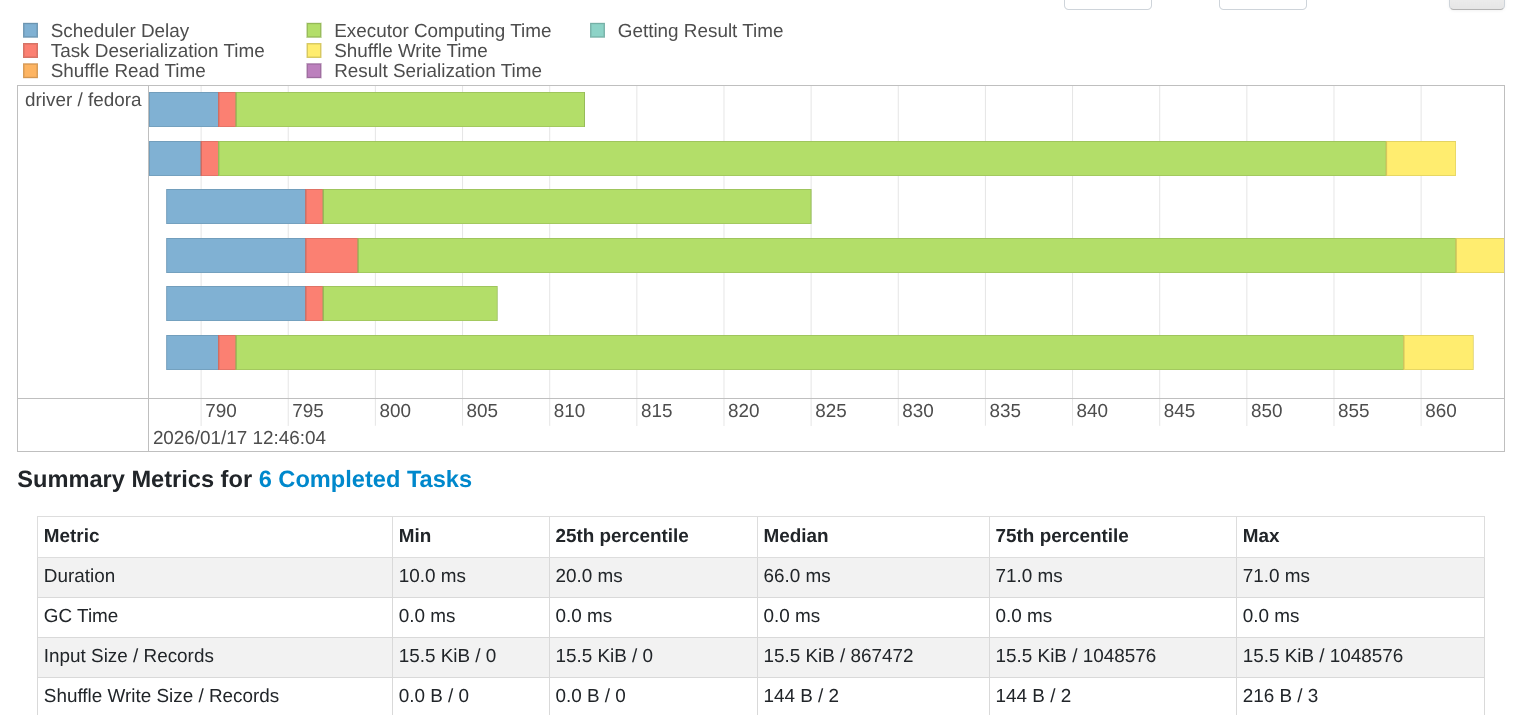


only tasks 2,4 and 6 handled data. Tasks 1,3 and 5 were "empty" tasks, but Spark still runs them to provide fault tolerance and coordination - tasks might fail . Bottomline is that Spark will always run one task per partition even if its empty.

In [ ]:
# Bonus: persisting results in the catalog

In [ ]:
# the catalog is still empty because DataFrames are not persisted
spark.catalog.listTables()

In [ ]:
# persisting the dataframe as a table in the catalog. This creates a new directory in the project /spark-warehouse
df_result.createOrReplaceTempView("vendor_revenue")

spark.catalog.listTables()

# Analyzing execution plan 

In [29]:
# Write out how Spark constructed the result of the GroupBy and agg action above
df_result.explain(True)

== Parsed Logical Plan ==
'Aggregate ['VendorID], ['VendorID, unresolvedalias('sum(fare_amount#3038)), unresolvedalias('sum(trip_distance#3032))]
+- Relation [VendorID#3028L,tpep_pickup_datetime#3029,tpep_dropoff_datetime#3030,passenger_count#3031,trip_distance#3032,RatecodeID#3033,store_and_fwd_flag#3034,PULocationID#3035L,DOLocationID#3036L,payment_type#3037L,fare_amount#3038,extra#3039,mta_tax#3040,tip_amount#3041,tolls_amount#3042,improvement_surcharge#3043,total_amount#3044,congestion_surcharge#3045,Airport_fee#3046] parquet

== Analyzed Logical Plan ==
VendorID: bigint, sum(fare_amount): double, sum(trip_distance): double
Aggregate [VendorID#3028L], [VendorID#3028L, sum(fare_amount#3038) AS sum(fare_amount)#3100, sum(trip_distance#3032) AS sum(trip_distance)#3101]
+- Relation [VendorID#3028L,tpep_pickup_datetime#3029,tpep_dropoff_datetime#3030,passenger_count#3031,trip_distance#3032,RatecodeID#3033,store_and_fwd_flag#3034,PULocationID#3035L,DOLocationID#3036L,payment_type#3037L,f

## Each plan abstracts the result on a different level:

### 1. Parsed logical plan: Raw syntax tree 
No intelligence, just literal structure of how df_result is defined

### 2. Analyzed logical plan: semantic + validation
Which columns and what datatypes and validates that columns exist in the Parquet schema

### 3. Optimized logical plan: optimization (Catalyst)
Take into account only 3 columns, as seen in additional "+- Project" line output. Saving time on reading 18 non-used columns.

### 4. Physical plan: Concrete execution
* FileScan: read 3 columns in parquet-file
* HashAggregate: aggregate on VendorID and calculate partial(!) sum of fare_amount and trip_distance
* Exchange hashpartitioning: Shuffle stage, all partial results from the previous step get written to one of 200 partitions by hash(VendorID)
* Hashaggregate: sum all partial sums and output final rows

# TO DO:

### Check efficiency gains with larger datasets